In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

print("Initalized")

Initalized


Table of Content
- [First Look](#First-Look)
- [Redo](#Redo)
- [Bonus](#Bonus)

# First Look

In [2]:
# Read the data
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None, na_values='"-"')
# From the https://ds.codeup.com/anomaly-detection/time-series-anomaly-detection-part-3/ rename columns as needed
data.columns=['date', 'time', 'page_viewed','user_id','cohort_id','ip']
# Combine the date time columns and set to datetime object
data['datetime'] = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(data.datetime)
#Set the index to the new datetime column and sort it
data = data.set_index('datetime')
data['hour'] = data.index.hour
data.head()

,date,time,page_viewed,user_id,cohort_id,ip,hour
datetime,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,9
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,9
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,9
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,9
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,9


In [3]:
# Create an entropy function
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

compute_entropy(data['cohort_id'])

3.9027926786187983

In [4]:
# Look at the total null values
data.ip.count()

719459

In [5]:
#create a data frame that gets the number of hits per hour date, the probaility of that, and the probaility of having a hit at a certain hour
hour_hits = pd.DataFrame(data['ip'].resample('H').count())
hour_hits.columns=['hits']
hour_hits['hits_proba'] = hour_hits['hits']/data.ip.count()
hour_hits['hour'] = hour_hits.index.hour
temp = hour_hits[['hits', 'hour']].groupby('hour').sum()
temp.reset_index(inplace=True)
temp.columns=['hour', 'hits_by_hour_total']
hour_hits = hour_hits.reset_index().merge(temp, how="left", on='hour').set_index('datetime')
hour_hits['hits_by_hour_proba'] = hour_hits['hits']/hour_hits['hits_by_hour_total']
hour_hits = hour_hits[['hits', 'hour', 'hits_proba', 'hits_by_hour_proba']]
hour_hits

,hits,hour,hits_proba,hits_by_hour_proba
datetime,,,,
2018-01-26 09:00:00,11,9,0.000015,0.000107
2018-01-26 10:00:00,63,10,0.000088,0.000883
2018-01-26 11:00:00,101,11,0.000140,0.001368
2018-01-26 12:00:00,28,12,0.000039,0.000707
2018-01-26 13:00:00,54,13,0.000075,0.000883
...,...,...,...,...
2020-11-02 12:00:00,106,12,0.000147,0.002677
2020-11-02 13:00:00,531,13,0.000738,0.008683
2020-11-02 14:00:00,217,14,0.000302,0.002994


In [6]:
data.resample('H')['ip'].value_counts()

datetime             ip             
2018-01-26 09:00:00  97.105.19.61        11
2018-01-26 10:00:00  97.105.19.61        61
                     71.137.146.71        2
2018-01-26 11:00:00  97.105.19.61       101
2018-01-26 12:00:00  97.105.19.61        22
                                       ... 
2020-11-02 16:00:00  173.172.202.149      1
                     70.121.134.234       1
                     70.121.201.159       1
                     70.94.150.75         1
                     99.43.143.116        1
Name: ip, Length: 97835, dtype: int64

In [7]:
# Make a df of the total views per page
page_views = pd.DataFrame(data['page_viewed'].value_counts()).reset_index()
page_views.columns=['page', 'total_page_views']

# Merge the page views on the original data frame
data = data.merge(page_views, how='left', left_on='page_viewed', right_on='page')
# Drop the page_viewed columns
data.drop(columns=['page_viewed'])
data

,date,time,page_viewed,user_id,cohort_id,ip,hour,page,total_page_views
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,9,/,40122.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,9,java-ii,10374.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,9,java-ii/object-oriented-programming,5241.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,9,slides/object_oriented_programming,487.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,9,javascript-i/conditionals,5184.0
...,...,...,...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,16,javascript-i/coffee-project,2895.0
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,16,javascript-i/mapbox-api,2567.0
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,16,javascript-i/coffee-project,2895.0
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,16,javascript-i/bom-and-dom/bom,3516.0


In [8]:
# Create a dataframe that is grouped by user_id and cohort_id that that counts the number of times each page was viewed by the pair
user_viewed = pd.DataFrame(data[['user_id', 'cohort_id', 'page_viewed']].groupby(['user_id', 'cohort_id'])['page_viewed'].value_counts())
user_viewed.columns=['times_viewed']
user_viewed.reset_index(inplace=True)

#create a dataframe that gets the number of times a page was viewed total per cohort
total_viewed = user_viewed[['cohort_id', 'page_viewed', 'times_viewed']].groupby(['cohort_id', 'page_viewed']).sum().reset_index()
total_viewed.columns=['cohort_id', 'page_viewed', 'total_cohort_views']
user_viewed = user_viewed.merge(total_viewed, on=['cohort_id', 'page_viewed'], how='left') 
# Create the percent viewed 
user_viewed['percent_viewed'] = user_viewed['times_viewed']/user_viewed['total_cohort_views']
user_viewed.sort_values(by=['cohort_id','user_id'])

,user_id,cohort_id,page_viewed,times_viewed,total_cohort_views,percent_viewed
2458,11,1.0,/,237,622,0.381029
2459,11,1.0,javascript-i,150,294,0.510204
2460,11,1.0,html-css,104,215,0.483721
2461,11,1.0,java-ii,85,167,0.508982
2462,11,1.0,javascript-ii,84,204,0.411765
...,...,...,...,...,...,...
89119,776,62.0,mysql/intellij,1,2,0.500000
89120,776,62.0,mysql/sample-database,1,1,1.000000
89121,776,62.0,search/search_index.json,1,121,0.008264
89122,776,62.0,slides/introduction_to_java,1,1,1.000000


In [9]:
# Create a data frame with that groups by user_id, cohort_id that counts the number of total visits for the pair
hits = user_viewed[['user_id','cohort_id']].groupby(['user_id','cohort_id']).size().reset_index()
hits.columns=['user_id', 'cohort_id', 'hits']
# Create a dataframe that sums up the number of hits per cohort
total_hits = hits[['hits','cohort_id']].groupby('cohort_id').sum().reset_index()
total_hits.columns=['cohort_id', 'total_hits_for_cohort']
#merge the two data frames
hits = hits.merge(total_hits, on='cohort_id', how='left')
hits

,user_id,cohort_id,hits,total_hits_for_cohort
0,1,8.0,248,309
1,1,28.0,774,5576
2,2,22.0,151,4811
3,3,22.0,169,4811
4,4,22.0,143,4811
...,...,...,...,...
743,783,59.0,13,3314
744,784,61.0,33,2416
745,785,59.0,14,3314
746,786,56.0,6,3178


# Redo
Needed a fresh look at the data and attemp to gain insights

In [10]:
# Read the data
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None, na_values='"-"')
# From the https://ds.codeup.com/anomaly-detection/time-series-anomaly-detection-part-3/ rename columns as needed
data.columns=['date', 'time', 'page_viewed','user_id','cohort_id','ip']
# Combine the date time columns and set to datetime object
data['datetime'] = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(data.datetime)
#Set the index to the new datetime column and sort it
data = data.set_index('datetime')
# Create columns for hour, day of week, and month
data['hour'] = data.index.hour
data['day'] = data.index.day_name()
data['month'] = data.index.month
# Print the head
data.head()

,date,time,page_viewed,user_id,cohort_id,ip,hour,day,month
datetime,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,9,Friday,1
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,9,Friday,1
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,9,Friday,1
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,9,Friday,1
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,9,Friday,1


In [11]:
# Check for percentage of null values
data.isnull().mean()

date           0.000000
time           0.000000
page_viewed    0.000001
user_id        0.000000
cohort_id      0.062325
ip             0.000000
hour           0.000000
day            0.000000
month          0.000000
dtype: float64

In [12]:
# Create a data frame to see the probaility for hits by hour of the day
hour_probaility = pd.DataFrame(data['hour'].value_counts()/data.shape[0]).reset_index()
hour_probaility.columns=['hour', 'probaility']
hour_probaility.sort_values(by='hour')
#store values with a probaility under 1.5% in a list
hours = hour_probaility[hour_probaility['probaility'] < .015]['hour']

In [13]:
# Probaility of hits happening during the hours listed
data[data.hour.isin(hours)].shape[0]/data.shape[0]

0.048629595293129976

In [14]:
# Create a data frame to see the probaility for page viws 
page_prob = pd.DataFrame(data['page_viewed'].value_counts()/data.shape[0]).reset_index()
page_prob.columns=['page', 'probaility']
page_prob.sort_values(by='probaility',ascending=True)
#store values with a probaility under .00001 in a list
pages = page_prob[page_prob['probaility'] < .00001]['page']
pages

1236                       5-regression/built-in-datasets
1237              appendix/univariate_regression_in_excel
1238                  appendix/further-reading/pagination
1239                  6-classification/6.3-random-forests
1240                                    11._DistributedML
                              ...                        
2148                                         css-ii/grids
2149                               content/git/index.html
2150                                                3-sql
2151     content/examples/javascript/primitive-types.html
2152    10-anomaly-detection/2-continuous-probabilisti...
Name: page, Length: 917, dtype: object

In [15]:
# Probaility of hits happening during the hours listed
possible = data[(data.page_viewed.isin(pages)) & (data.hour.isin(hours))]
possible

,date,time,page_viewed,user_id,cohort_id,ip,hour,day,month
datetime,,,,,,,,,
2018-01-27 06:55:41,2018-01-27,06:55:41,git/branching,38,21.0,173.174.155.172,6,Saturday,1
2018-01-27 07:49:25,2018-01-27,07:49:25,teams/13,1,8.0,72.177.226.58,7,Saturday,1
2018-01-29 00:05:14,2018-01-29,00:05:14,jquery/resume-portfolio,54,NaN,24.160.159.122,0,Monday,1
2018-02-02 23:53:08,2018-02-02,23:53:08,content/appendix/angular/templating.html,51,13.0,72.179.161.39,23,Friday,2
2018-02-02 23:55:39,2018-02-02,23:55:39,content/appendix/angular/models.html,51,13.0,72.179.161.39,23,Friday,2
...,...,...,...,...,...,...,...,...,...
2020-11-01 03:01:30,2020-11-01,03:01:30,advanced-topics/intro-to-flask,730,61.0,68.203.188.247,3,Sunday,11
2020-11-01 03:02:00,2020-11-01,03:02:00,advanced-topics/html-templates,730,61.0,68.203.188.247,3,Sunday,11
2020-11-01 03:02:30,2020-11-01,03:02:30,advanced-topics/html-forms,730,61.0,68.203.188.247,3,Sunday,11


Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

In [16]:
data.shape[0]

719459

In [45]:
# Create a dataframe that groups by user_id and cohort_id and then resamples by D to get the number of hits by user + cohort perday
test = pd.DataFrame(data.groupby(['user_id', 'cohort_id']).resample('D').size())
# Reset the index and then set the index to datetime
test = test.reset_index().set_index('datetime')
# Rename the columns as needed
test.columns=['user_id', 'cohort_id', 'hits']
# Print
test

,user_id,cohort_id,hits
datetime,,,
2018-01-26,1,8.0,7
2018-01-27,1,8.0,1
2018-01-28,1,8.0,0
2018-01-29,1,8.0,6
2018-01-30,1,8.0,5
...,...,...,...
2020-10-31,785,59.0,0
2020-11-01,785,59.0,0
2020-11-02,785,59.0,9


In [41]:
short_rolling = pd.DataFrame(test[['user_id', 'cohort_id', 'hits']].groupby(['user_id', 'cohort_id'])['hits'].rolling(window=7).mean())
long_rolling = pd.DataFrame(test[['user_id', 'cohort_id', 'hits']].groupby(['user_id', 'cohort_id'])['hits'].rolling(window=30).mean())
short_rolling = short_rolling.reset_index().set_index('datetime')
long_rolling = long_rolling.reset_index().set_index('datetime')
long_rolling.columns=['user_id', 'cohort_id', '30dayroll']
short_rolling.columns=['user_id', 'cohort_id', '7dayroll']


test = test.merge(short_rolling, on=['user_id', 'cohort_id', 'datetime'], how='inner')
test = test.merge(long_rolling, on=['user_id', 'cohort_id', 'datetime'], how='inner')
test

,user_id,cohort_id,hits,7dayroll,30dayroll
datetime,,,,,
2018-01-26,1,8.0,7,NaN,NaN
2018-01-27,1,8.0,1,NaN,NaN
2018-01-28,1,8.0,0,NaN,NaN
2018-01-29,1,8.0,6,NaN,NaN
2018-01-30,1,8.0,5,NaN,NaN
...,...,...,...,...,...
2020-10-31,785,59.0,0,NaN,NaN
2020-11-01,785,59.0,0,3.142857,NaN
2020-11-02,785,59.0,9,4.285714,NaN


<AxesSubplot:xlabel='datetime,cohort_id,user_id'>

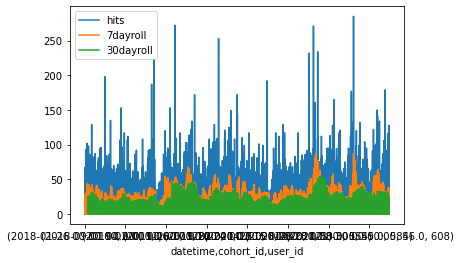

In [19]:
test.groupby(['datetime', 'cohort_id', 'user_id']).mean().plot()

In [43]:
ema_short = test['hits'].ewm(span=7, adjust=False).mean()
ema_short

datetime
2018-01-26    7.000000
2018-01-27    5.500000
2018-01-28    4.125000
2018-01-29    4.593750
2018-01-30    4.695312
                ...   
2020-10-31    4.216723
2020-11-01    3.162542
2020-11-02    4.621907
2020-10-29    5.216430
2020-10-29    4.162322
Name: hits, Length: 187090, dtype: float64

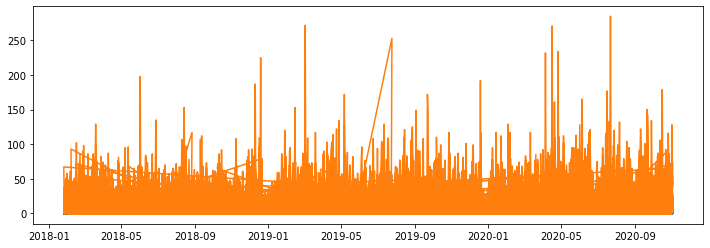

In [46]:
span = 30
ema_long = test['hits'].ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-30:-1].std()*3
lb = midband - ema_long[-30:-1].std()*3

pct_b = pd.DataFrame({'pct_b': (test['hits']-lb)/(ub-lb)})
sac = pd.DataFrame(test['hits'])
sac = pd.concat([test, pct_b], axis=1)

plt.figure(figsize=(12,4))
plt.plot(sac.pct_b)
plt.plot(sac.hits)


In [21]:

# Non time series method 
cohortmin = data[['cohort_id', 'date', 'user_id']].groupby(['cohort_id', 'user_id'])['date'].min().reset_index()
cohortmax = data[['cohort_id', 'date', 'user_id']].groupby(['cohort_id', 'user_id'])['date'].max().reset_index()
cohortmax.columns=['cohort_id', 'user_id', 'max_date']
cohortmin.columns=['cohort_id', 'user_id', 'start_date']

cohort = cohortmin.merge(cohortmax, on=['cohort_id', 'user_id'], how='left')
cohort['max_date'] = pd.to_datetime(cohort.max_date)
cohort['start_date'] = pd.to_datetime(cohort.start_date)
cohort['days_used'] = (cohort['max_date'] - cohort['start_date']).dt.days
cohort[cohort['days_used'] > 540]['user_id']

6      148
7      170
26      88
39     245
43     101
      ... 
376    333
384    341
389    346
403    385
407    389
Name: user_id, Length: 90, dtype: int64

# Bonus

In [23]:
cohort = data[['date', 'cohort_id', 'user_id']].groupby(['cohort_id', 'user_id']).min().reset_index()
cohort[cohort['cohort_id']==1]

,cohort_id,user_id,date
0,1.0,11,2018-01-26
1,1.0,60,2018-01-29
2,1.0,64,2018-01-29
3,1.0,95,2018-02-10
4,1.0,141,2018-03-14
5,1.0,146,2018-03-19
6,1.0,148,2018-03-19
7,1.0,170,2018-04-16
8,1.0,209,2018-06-01
9,1.0,211,2018-06-11
